# 1. Prerequisite

## 1.1. Modules

In [0]:
import os
from os import path
from google.colab import drive
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import math
try:
  %tensorflow_version 1.x
except:
  pass
import tensorflow as tf


## 1.2. Path

In [0]:
now = datetime.now()
drive.mount('/content/gdrive')

notebook_path_name = './gdrive/My Drive/2019/FLEMG/공유자료함/실험/20200126'
#notebook_path_name = '각자 알아서 맞출것'

if not path.exists(notebook_path_name):
  print('Check your google drive directory. See you file explorer')
with open(path.join(notebook_path_name, "test.txt"), "w") as f:
    f.write("test well saved!!!")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
subject_name = "JYLee"
network_name = "Network_feedback_flex_features"
time_name = now.strftime("%Y%m%d_%H%M")    
model_name = notebook_path_name + '/model/' + network_name

try:
# Create target Directory
    os.makedirs(model_name)
    print("Directory " , model_name ,  " Created\n") 
    subject_dir = model_name + '/' + subject_name
    try:
        os.makedirs(subject_dir)
        print("Directory" , subject_dir , "Created\n")
    except FileExistsError:
        print("Directory " , subject_dir ,  " already exists\n")
except FileExistsError:
    subject_dir = model_name + '/' + subject_name
    try:
        os.makedirs(subject_dir)
        print("Directory" , subject_dir , "Created\n")
    except FileExistsError:
        print("Directory " , subject_dir ,  " already exists\n")

model_dir = subject_dir + '/' +time_name

fig_name =  notebook_path_name + "/result/" + network_name
try:
# Create target Directory
    os.makedirs(fig_name)
    print("Directory " , fig_name ,  " Created\n") 
    subject_dir = fig_name + "/" + subject_name
    try:
        os.makedirs(subject_dir)
        print("Directory",subject_dir,"Created\n")
    except FileExistsError:
        print("Directory",subject_dir,"already exists\n")

except FileExistsError:
    subject_dir = fig_name + "/" + subject_name
    try:
        os.makedirs(subject_dir)
        print("Directory",subject_dir,"Created\n")
    except FileExistsError:
        print("Directory",subject_dir,"already exists\n")
fig_dir = subject_dir

Directory  ./gdrive/My Drive/2019/FLEMG/공유자료함/실험/20200126/model/Network_feedback_flex_features  Created

Directory ./gdrive/My Drive/2019/FLEMG/공유자료함/실험/20200126/model/Network_feedback_flex_features/JYLee Created

Directory  ./gdrive/My Drive/2019/FLEMG/공유자료함/실험/20200126/result/Network_feedback_flex_features  Created

Directory ./gdrive/My Drive/2019/FLEMG/공유자료함/실험/20200126/result/Network_feedback_flex_features/JYLee Created



# 2. Preprocessor

In [0]:
class encoder:
    def __init__(self, queue_list = [], index_dim = 1, flex_dim = 5, emg_dim = 8, seq_length = 3, emg_active_dim = 4):
        self.queue_list = queue_list
        self.dataSet = []
        self.count = 0
		
        self.emg_dim = emg_dim
        self.flex_dim = flex_dim
        self.index_dim = index_dim
        self.data_dim =  emg_dim+flex_dim
        self.label_dim = flex_dim
        self.seq_length = seq_length
        self.emg_active_dim = emg_active_dim

        self.tmp_I = 0
        self.tmp_E = []
        self.tmp_F = []

## 2.1. Data Preparation

In [0]:
subject_name = "JYLee"
subject_dir = notebook_path_name + '/data/' + subject_name
target_dir = subject_dir + '/6_All'

training_file = target_dir + "/20200122_2243_encode" + ".csv"
testing_file = target_dir + "/20200122_2241_encode" + ".csv"

In [0]:
class data_loader:
	def __init__(self, en = encoder(), raw = []):
		self.raw = raw
		self.encoder = en
		self.data = []
		self.label = []
		self.index = []

	def load(self, location='default', delimiter = ','):
		self.raw = np.loadtxt(location, delimiter = delimiter)

In [0]:
emg_dim = 8
flex_dim = 5

EC = encoder(emg_dim = emg_dim ,flex_dim = flex_dim)
DL = data_loader(en = EC)
DL.load(training_file)
raw_data = DL.raw

print(f"{np.asarray(raw_data).shape}")
print(f"{raw_data[0]}")

(46583, 14)
[ 1.60681634e+00  2.90751000e+02  3.78200400e+03  4.49797600e+03
  6.59740800e+03 -1.87500016e+05 -1.87500016e+05 -1.87500016e+05
 -1.87500016e+05  3.30000000e+02  3.83000000e+02  3.74000000e+02
  3.67000000e+02  3.91000000e+02]


## 2.2. Crop Abnormal Data

In [0]:
# EMG 첫번째 채널 이상한 값 없애기
class cropper:
  def __init__(self, en = encoder(), raw = []):
    self.raw = raw
    self.encoder = en
    self.data = []
    self.label = []
    self.index = []

  def delete_abnormal_sEMG(self, feature_window = 50, data = None):
    if data is not None:
      self.raw = np.asarray(data)

    res = []
    for i in range(len(self.raw)):
      if i > feature_window/2:
        mean = np.mean( self.raw[ int(i-feature_window/2) : int(i+feature_window/2), 1] )
        rms = np.sqrt( np.mean( self.raw[ int(i-feature_window/2) : int(i+feature_window/2), 1]**2 ) )

        if mean-rms*0.8 <= self.raw[i, self.encoder.index_dim] <= mean+rms*0.8 :
          res.append(self.raw[i])
        else:
          pass
    return np.asarray(res)

46583
46383


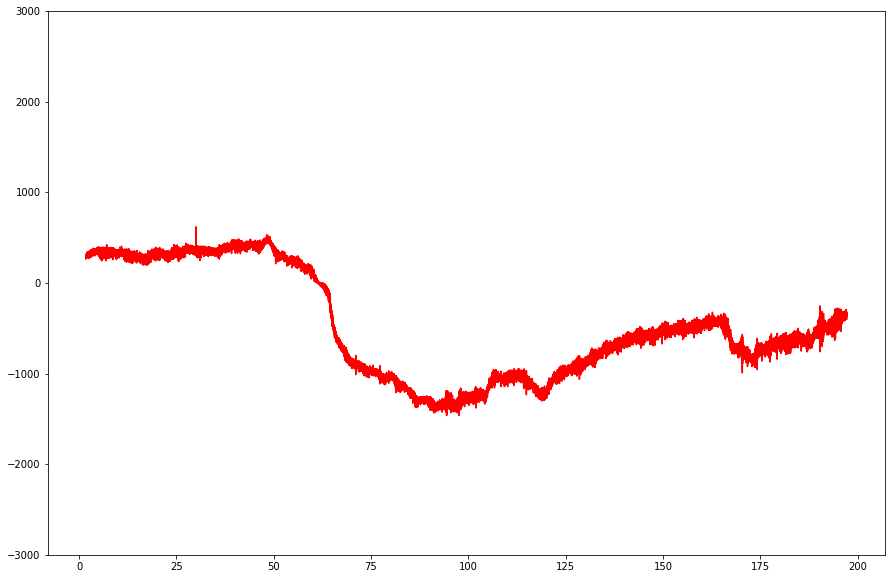

In [0]:
CR = cropper(en = EC, raw = raw_data)
crop_data = CR.delete_abnormal_sEMG()
print(len(raw_data))
print(len(crop_data))

fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.ylim([-3000,3000])
index = crop_data[:,0]
sEMGdata = crop_data[:,1]
plt.plot(index[:], sEMGdata[:],'r')

## 2.3. Filtering

In [0]:
class filtering:
    def __init__(self, en = encoder(), raw = []):
        self.raw = raw
        self.encoder = en
        self.data = []
        self.label = []
        self.index = []
        
    def butter_highpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
        return b, a

    def butter_highpass_filter(self, data, cutoff, fs, order=5):
        b, a = self.butter_highpass(cutoff, fs, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def filter_highpass(self, data = None, cutoff = 10, fps = 250):
        if data is not None:
            self.raw = np.asarray(data)
        
        filtered_data = []
        filtered_data.append( self.raw[:,0] )
        for ch in range(emg_dim):
          sEMGdata = self.raw[:,ch+1]
          sEMGfiltered = self.butter_highpass_filter(sEMGdata, cutoff, fps)
          filtered_data.append(sEMGfiltered)

        for ch in range(flex_dim):
          filtered_data.append( self.raw[:, 9+ch])

        filtered_data = np.asarray(filtered_data).transpose()
        return filtered_data

In [0]:
FT = filtering(en = EC, raw = crop_data)
filtered_data = FT.filter_highpass(cutoff = 10)

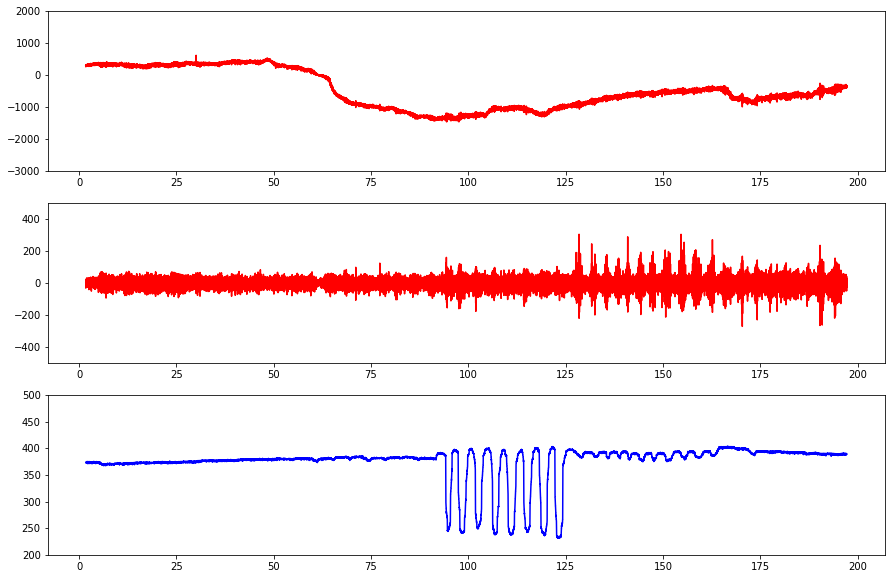

In [0]:
index = crop_data[:,0]
sEMGdata = crop_data[:,1]
flexdata = crop_data[:,11]

fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.subplot(311)
plt.ylim([-3000,2000])
plt.plot(index[:], sEMGdata[:],'r')

plt.subplot(312)
plt.ylim([-500,500])
plt.plot(index[:], filtered_data[:,2],'r')

plt.subplot(313)
plt.ylim([200,500])
plt.plot(index[:], flexdata[:],'b')

plt.show()


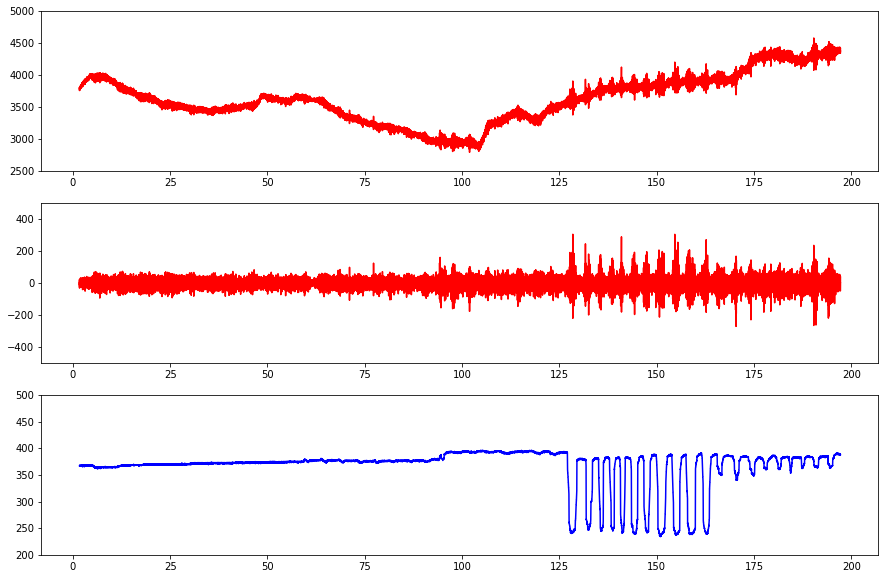

In [0]:
index = crop_data[:,0]
sEMGdata = crop_data[:,2]
flexdata = crop_data[:,12]

fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.subplot(311)
plt.ylim([2500,5000])
plt.plot(index[:], sEMGdata[:],'r')

plt.subplot(312)
plt.ylim([-500,500])
plt.plot(index[:], filtered_data[:,2],'r')

plt.subplot(313)
plt.ylim([200,500])
plt.plot(index[:], flexdata[:],'b')

plt.show()


## 2.4. Feature Extraction
(1) Mean Absolute Value, (2) Simple Square Integral, (3) Root Mean Square, (4) WaveForm Length, (5) Zero Crossing 

In [0]:
class feature_extractor:
	def __init__(self, en = encoder(), raw = []):
		self.raw = raw
		self.encoder = en
		self.data = []
		self.label = []
		self.index = []

	def feature_extraction(self, feature_window = 2**8, data = None):
		if data is not None:
			self.raw = np.asarray(data)

		res = []
		for i in range(len(self.raw)):
			if i > feature_window:
				tmp = [self.raw[i, 0]]

				# Raw (Filtered) Data
				for ch in range(self.encoder.emg_dim):
					tmp.append( self.raw[i, self.encoder.index_dim+ch] )
				
				# Mean Absolute Value
				for ch in range(self.encoder.emg_dim):
					ab = 0
					for r in range(feature_window):
						ab += abs(self.raw[i-r, self.encoder.index_dim+ch])
					tmp.append( ab/feature_window )

				# Simple Square Integral
				for ch in range(self.encoder.emg_dim):
					si = 0
					for r in range(feature_window):
						si += (self.raw[i-r, self.encoder.index_dim+ch])**2
					tmp.append( si )
		 
				# Root Mean Square
				for ch in range(self.encoder.emg_dim):
					rms = 0
					for r in range(feature_window):
						rms += (self.raw[i-r, self.encoder.index_dim+ch])**2
					tmp.append( (rms/feature_window)**(0.5) )
				
				# WaveForm Length
				for ch in range(self.encoder.emg_dim):
					wl = 0
					for r in range(feature_window-1):
						wl += abs( self.raw[i - r , self.encoder.index_dim+ch] - self.raw[i - (r+1), self.encoder.index_dim+ch] )
					tmp.append( wl )
		 
				# Zero Crossing
				threshold = 0
				for ch in range(self.encoder.emg_dim):
					zc = 0
					for r in range(feature_window-1):
						if self.raw[i - r , self.encoder.index_dim+ch] > threshold and self.raw[i - (r+1) , self.encoder.index_dim+ch] < threshold:
							zc += 1
						elif self.raw[i - r , self.encoder.index_dim+ch] < threshold and self.raw[i - (r+1) , self.encoder.index_dim+ch] > threshold:
							zc += 1
					tmp.append( zc )


				tmp = np.concatenate( (tmp, self.raw[i, 1+self.encoder.emg_dim:]), axis=None)
					
				res.append(tmp.tolist())
		
				if i % 150 == 0 :
					print(f"{i}/{len(self.raw)}")
		
		print(res[0])
		return np.asarray(res)

In [0]:
seq_length = 2**8

FE = feature_extractor(en=EC, raw=filtered_data)
#FE = feature_extractor(en=Encoder, raw=raw_data)
feat_data = FE.feature_extraction(feature_window = seq_length)

print(len(feat_data[0]))
print(len(feat_data[0])- (1+5))

300/46383
450/46383
600/46383
750/46383
900/46383
1050/46383
1200/46383
1350/46383
1500/46383
1650/46383
1800/46383
1950/46383
2100/46383
2250/46383
2400/46383
2550/46383
2700/46383
2850/46383
3000/46383
3150/46383
3300/46383
3450/46383
3600/46383
3750/46383
3900/46383
4050/46383
4200/46383
4350/46383
4500/46383
4650/46383
4800/46383
4950/46383
5100/46383
5250/46383
5400/46383
5550/46383
5700/46383
5850/46383
6000/46383
6150/46383
6300/46383
6450/46383
6600/46383
6750/46383
6900/46383
7050/46383
7200/46383
7350/46383
7500/46383
7650/46383
7800/46383
7950/46383
8100/46383
8250/46383
8400/46383
8550/46383
8700/46383
8850/46383
9000/46383
9150/46383
9300/46383
9450/46383
9600/46383
9750/46383
9900/46383
10050/46383
10200/46383
10350/46383
10500/46383
10650/46383
10800/46383
10950/46383
11100/46383
11250/46383
11400/46383
11550/46383
11700/46383
11850/46383
12000/46383
12150/46383
12300/46383
12450/46383
12600/46383
12750/46383
12900/46383
13050/46383
13200/46383
13350/46383
13500/46383
13

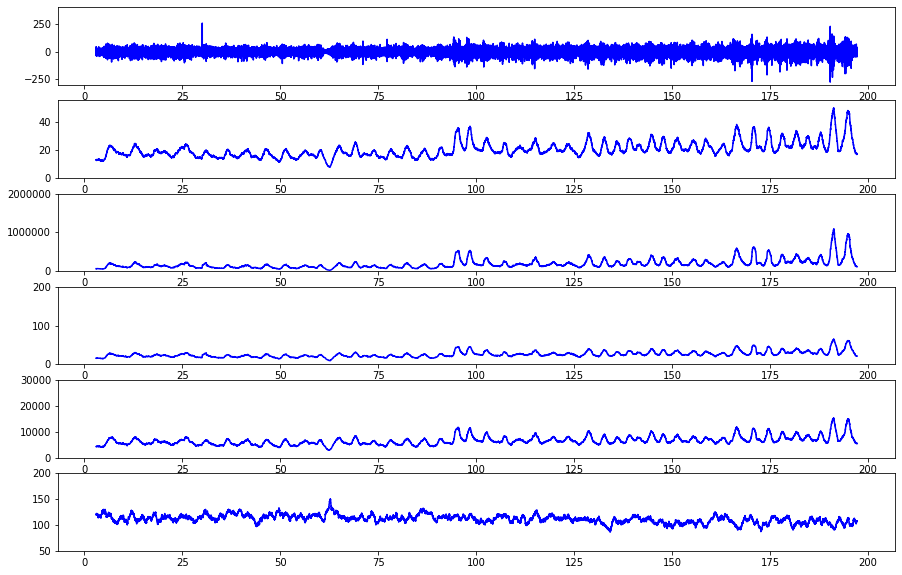

In [0]:
index = feat_data[:,0]

fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.subplot(611)
plt.ylim([-300,400])
plt.plot(index[:], feat_data[:,1],'b')

plt.subplot(612)
plt.ylim([0,55])
plt.plot(index[:], feat_data[:,9],'b')

plt.subplot(613)
plt.ylim([-200,2000000])
plt.plot(index[:], feat_data[:,17],'b')

plt.subplot(614)
plt.ylim([0,200])
plt.plot(index[:], feat_data[:,25],'b')

plt.subplot(615)
plt.ylim([0,30000])
plt.plot(index[:], feat_data[:,33],'b')

plt.subplot(616)
plt.ylim([50,200])
plt.plot(index[:], feat_data[:,41],'b')

plt.show()

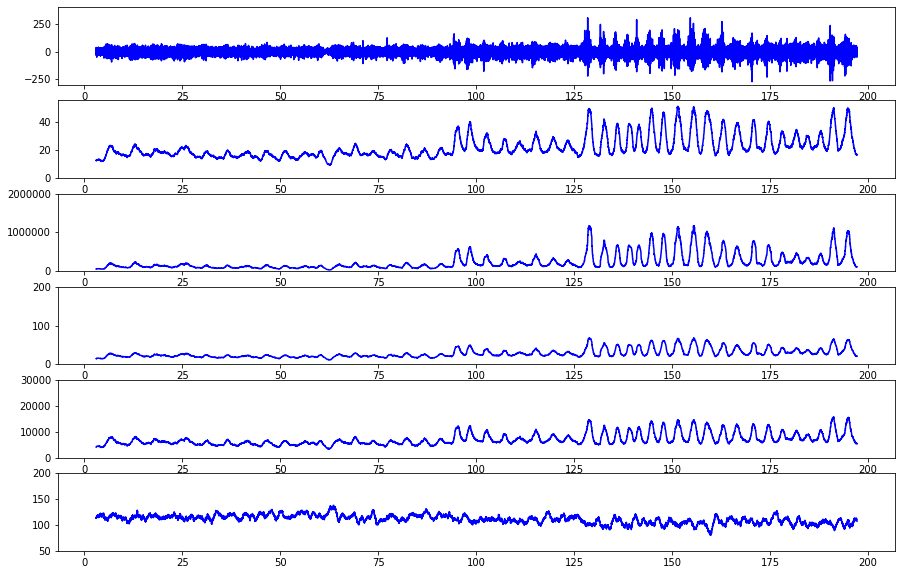

In [0]:
index = feat_data[:,0]

fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.subplot(611)
plt.ylim([-300,400])
plt.plot(index[:], feat_data[:,2],'b')

plt.subplot(612)
plt.ylim([0,55])
plt.plot(index[:], feat_data[:,10],'b')

plt.subplot(613)
plt.ylim([-200,2000000])
plt.plot(index[:], feat_data[:,18],'b')

plt.subplot(614)
plt.ylim([0,200])
plt.plot(index[:], feat_data[:,26],'b')

plt.subplot(615)
plt.ylim([0,30000])
plt.plot(index[:], feat_data[:,34],'b')

plt.subplot(616)
plt.ylim([50,200])
plt.plot(index[:], feat_data[:,42],'b')

plt.show()

## 2.5. Scaling

In [0]:
class scaler:
    def __init__(self, en = encoder(), raw = []):
        self.raw = raw
        self.encoder = en
        self.data = []
        self.label = []
        self.index = []
        
    def scale(self, data = None, emg_max = 187500.016, flex_max = 1024, feature_num = 5):
        if data is not None:
            self.raw = np.asarray(data)
        
        # scale EMG raw data
        #self.raw[:,self.encoder.index_dim:self.encoder.index_dim+self.encoder.emg_dim]/=emg_max
        #self.raw[:,self.encoder.index_dim:self.encoder.index_dim+self.encoder.emg_dim]=(self.raw[:,self.encoder.index_dim:self.encoder.index_dim+self.encoder.emg_dim]--0.08)/(0.08--0.08)

        # scale Flex-sensor data
        flex_start_idx = 1+ (self.encoder.emg_dim*(feature_num+1))
        self.raw[:,flex_start_idx:]/=flex_max
        self.raw[:,flex_start_idx:]=(self.raw[:,flex_start_idx:]-0.15)/(0.4-0.15)


In [0]:
SC = scaler(en = EC)
SC.scale(feat_data)
scale_data = SC.raw
print(scale_data[0])

[ 2.97769482e+00  1.56712389e+01  1.70242059e+01 -3.17577481e+01
 -8.22265486e+01 -6.96108824e-09 -6.96108824e-09 -6.96108824e-09
 -6.96108824e-09  1.27100026e+01  1.23720418e+01  1.83536264e+01
  4.68553499e+01  7.13336340e-09  7.13336340e-09  7.13336340e-09
  7.13336340e-09  6.28069752e+04  5.75388964e+04  1.60635469e+05
  7.16185043e+05  1.88753282e-14  1.88753282e-14  1.88753282e-14
  1.88753282e-14  1.56633249e+01  1.49920417e+01  2.50495968e+01
  5.28923229e+01  8.58671945e-09  8.58671945e-09  8.58671945e-09
  8.58671945e-09  4.28894932e+03  4.09834239e+03  6.58370698e+03
  1.59065505e+04  4.87439003e-07  4.87439003e-07  4.87439003e-07
  4.87439003e-07  1.21000000e+02  1.13000000e+02  1.20000000e+02
  1.23000000e+02  2.20000000e+01  2.20000000e+01  2.20000000e+01
  2.20000000e+01  6.92968750e-01  8.92187500e-01  8.57031250e-01
  8.37500000e-01  9.27343750e-01]


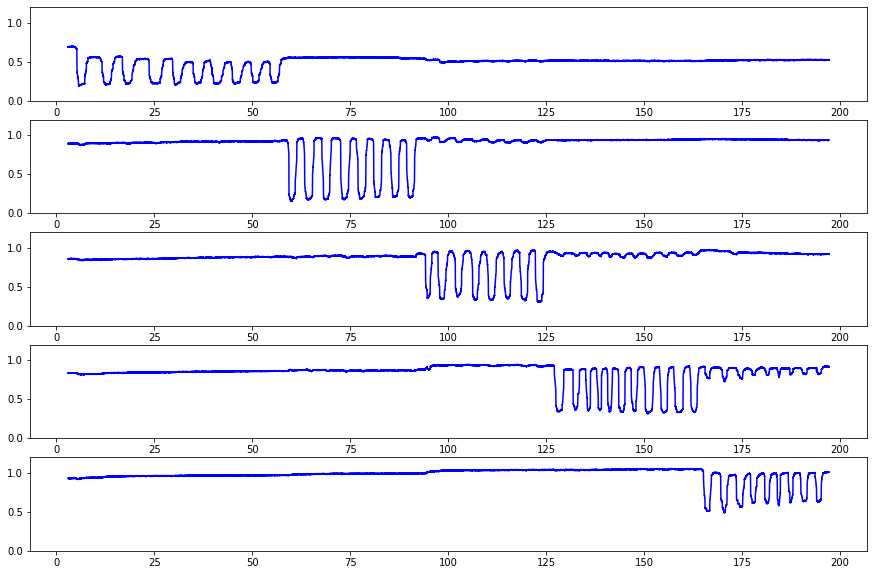

In [0]:
fig = plt.figure(num=1,figsize=(15,10))
plt.figure(1)
plt.subplot(511)
plt.ylim([0,1.2])
plt.plot(index[:], scale_data[:,49],'b')

plt.subplot(512)
plt.ylim([0,1.2])
plt.plot(index[:], scale_data[:,50],'b')

plt.subplot(513)
plt.ylim([0,1.2])
plt.plot(index[:], scale_data[:,51],'b')

plt.subplot(514)
plt.ylim([0,1.2])
plt.plot(index[:], scale_data[:,52],'b')

plt.subplot(515)
plt.ylim([0,1.2])
plt.plot(index[:], scale_data[:,53],'b')

plt.show()

## 2.6. Window Building

In [0]:
class window_builder:
	def __init__(self, en = encoder(), raw = []):
		self.raw = raw
		self.encoder = en
		self.data = []
		self.label = []
		self.index = []

	def preprocess_feedback_flex_features(self, data = None):
			if data is not None:
				self.raw = np.asarray(data)

			if (self.encoder.seq_length >= len(self.raw)):
				print(f"Error : seqence length {self.encoder.seq_length} is shorter than data count {len(self.raw)}")
				return

			dataX = []
			dataY = []
			dataT = []
			for i in range(len(self.raw) - self.encoder.seq_length + 1):
				_x = self.raw[i:i+self.encoder.seq_length, self.encoder.index_dim:]
				_y = self.raw[i+self.encoder.seq_length-1, self.encoder.data_dim+self.encoder.index_dim-self.encoder.label_dim:] 
				_t = self.raw[i:i+self.encoder.seq_length, :self.encoder.index_dim]
				dataX.append(_x)
				dataY.append(_y)
				dataT.append(_t)
			
			self.index = np.array(dataT)
			self.data = np.array(dataX)
			self.label = np.array(dataY)

			return self.index, self.data, self.label

In [0]:
EC_WB = encoder(emg_dim = 8 * 6, flex_dim = 5, seq_length = seq_length)
WB = window_builder(en = EC_WB, raw=feat_data)
trainIndex, trainData, trainLabel = WB.preprocess_feedback_flex_features(feat_data)

#print(f"Index example: {trainIndex[0].reshape(-1)}\nData example: {trainData[0]} \nLabel example: {trainLabel[0]}\n")
print(f"Data example: {trainData[0]} \nLabel example: {trainLabel[0]}\n")

# 3. Network

In [0]:
class network_feedback_flex:
	def __init__(self, data_encoder = encoder()):
		tf.set_random_seed(777)  # reproducibility
		self.data_encoder = data_encoder
		self.seq_length = data_encoder.seq_length
		self.data_dim = data_encoder.emg_dim + data_encoder.flex_dim
		self.output_dim = data_encoder.flex_dim
        
		self.graph = tf.Graph()
		self.sess = tf.Session()
        
		self.flag_kernel_opened = False
		self.flag_placeholder = False

	# build a LSTM network
	def build_cell(self):
		cell = tf.contrib.rnn.BasicLSTMCell(num_units = self.hidden_dim, state_is_tuple=True)
		return cell

	def construct_placeholders(self, learning_rate = 0.1, hidden_dim = 30, stack_dim = 2):
		self.learning_rate = learning_rate
		self.hidden_dim = hidden_dim
		self.stack_dim = stack_dim

		# Input Place holders
		self.X = tf.placeholder(tf.float32, [None, self.seq_length, self.data_dim])
		self.Y = tf.placeholder(tf.float32, [None, self.output_dim])

		# Build a LSTM network
		multi_cells = tf.contrib.rnn.MultiRNNCell([self.build_cell() for _ in range(self.stack_dim)], state_is_tuple=True)
		outputs, _states=tf.nn.dynamic_rnn(multi_cells, self.X, dtype=tf.float32)
		self.Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], self.output_dim)

		# Cost & Loss & Optimizer
		self.loss = tf.reduce_sum(tf.square(self.Y_pred - self.Y))  # sum of the squares
		self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
		self.train = self.optimizer.minimize(self.loss)

		# RMSE
		self.targets = tf.placeholder(tf.float32, [None, self.output_dim])
		self.predictions = tf.placeholder(tf.float32, [None, self.output_dim])
		self.rmse=[]
		for i in range(self.output_dim):
			rmse = tf.sqrt(tf.reduce_mean(tf.square(self.targets[:,i] - self.predictions[:,i])))
			self.rmse.append(rmse)
		#self.rmse = tf.sqrt(tf.reduce_mean(tf.square(self.targets - self.predictions)))
        
		self.flag_kernel_opened = True
		self.flag_placeholder = True
        
	def train_network(self, training_data = [], training_label = [], iterations = 5000, batch_size = 2**14, location = 'model/_'):
		self.sess = tf.Session(graph=self.graph)
		init = tf.global_variables_initializer()
		self.sess.run(init)
		self.loss_set=[]
		self.batch_size = batch_size

		# Training step
		for i in range(iterations):
			batch_loss = 0
			for idx in range( len(training_data)//self.batch_size ):
				if idx+self.batch_size < len(training_data):
					_, step_loss = self.sess.run([self.train, self.loss], feed_dict={self.X: training_data[idx:idx+self.batch_size], self.Y: training_label[idx:idx+self.batch_size]})
					batch_loss += step_loss
				else :
					_, step_loss = self.sess.run([self.train, self.loss], feed_dict={self.X: training_data[idx:], self.Y: training_label[idx:]})
					batch_loss += step_loss

			self.loss_set.append(batch_loss)
			print(f"[iter: {i}/{iterations}] loss: {batch_loss}")

		#train_predict = self.sess.run(self.Y_pred, feed_dict={self.X: training_data})
    
		# Save Network
		self.saver = tf.train.Saver()
		#location = location + "(" + str(self.stack_dim) + ")"
		self.saver.save(self.sess, location+"/lstm.ckpt")
		return self.loss_set

	def restore(self, location='model/_'):
		if (not self.flag_placeholder) :
			self.construct_placeholders()
		if (os.path.exists(location) == False):
			print("Error : No such location")
			return
		self.sess = tf.Session(graph=self.graph)

		self.saver = tf.train.Saver()
		self.saver.restore(self.sess, tf.train.latest_checkpoint(location))

	def infer(self, testSet = [], testLabel = None, default_ = 0.39):
		prediction = []
		for idx in range( len(testSet) ):
			# testSet Reconstruction
			if idx == 0:
				for l in range(self.data_encoder.seq_length):
					for j in range(self.data_encoder.label_dim):
						pass
						#testSet[idx, l, self.data_encoder.emg_dim + j] = default_
						#testSet[idx, l, self.data_encoder.emg_dim + j] = random.random()
			else:
				for l in range(self.data_encoder.seq_length):
					for j in range(self.data_encoder.label_dim):
						if l == self.data_encoder.seq_length - 1:
							testSet[idx, l, self.data_encoder.emg_dim + j] = test_predict[0][j]
						else:
							testSet[idx, l, self.data_encoder.emg_dim + j] = testSet[idx-1, l+1, self.data_encoder.emg_dim + j]

			# Feed testData
			#print(f"{idx} test\n{testSet[idx,:,8:]}\n")
			test_predict = self.sess.run(self.Y_pred, feed_dict= {self.X: [testSet[idx]]})
			prediction.append(test_predict[0])
	 
			if idx % 100 == 0 :
				print(f"{idx}/{len(testSet)} pred : {test_predict[0]}")
		
		# Calculate RMSE	
		if testLabel is not None:
			rmse_val = self.sess.run(self.rmse, feed_dict={self.targets: testLabel, self.predictions: prediction})
			print(f"RMSE: {rmse_val}\n")
			return prediction, rmse_val
		return prediction


	def close(self):
		tf.reset_default_graph()
		self.sess.close()

## 3.0. Test Dataset

In [0]:
DL.load(testing_file)

CR = cropper(en = EC, raw = DL.raw)
CR_data = CR.delete_abnormal_sEMG()

FT_data = FT.filter_highpass(data = CR_data, cutoff=10)

FE = feature_extractor(en=EC, raw=FT_data)
FE_data = FE.feature_extraction(feature_window = seq_length)

SC.scale(FE_data)
SC_data = SC.raw

testIndex, testData, testLabel = WB.preprocess_feedback_flex_features(data=FE_data)

#print(f"Index example: {testIndex[0].reshape(-1)}\nData example: {testData[0]} \nLabel example: {testLabel[0]}\n")
print(f"Data example: {testData[0]} \nLabel example: {testLabel[0]}\n")

300/16623
450/16623
600/16623
750/16623
900/16623
1050/16623
1200/16623
1350/16623
1500/16623
1650/16623
1800/16623
1950/16623
2100/16623
2250/16623
2400/16623
2550/16623
2700/16623
2850/16623
3000/16623
3150/16623
3300/16623
3450/16623
3600/16623
3750/16623
3900/16623
4050/16623
4200/16623
4350/16623
4500/16623
4650/16623
4800/16623
4950/16623
5100/16623
5250/16623
5400/16623
5550/16623
5700/16623
5850/16623
6000/16623
6150/16623
6300/16623
6450/16623
6600/16623
6750/16623
6900/16623
7050/16623
7200/16623
7350/16623
7500/16623
7650/16623
7800/16623
7950/16623
8100/16623
8250/16623
8400/16623
8550/16623
8700/16623
8850/16623
9000/16623
9150/16623
9300/16623
9450/16623
9600/16623
9750/16623
9900/16623
10050/16623
10200/16623
10350/16623
10500/16623
10650/16623
10800/16623
10950/16623
11100/16623
11250/16623
11400/16623
11550/16623
11700/16623
11850/16623
12000/16623
12150/16623
12300/16623
12450/16623
12600/16623
12750/16623
12900/16623
13050/16623
13200/16623
13350/16623
13500/16623
13

## 3.1. Training


In [0]:
subject = subject_name
seq_length = seq_length

learning_rate = 2**(-3)
iteration = 2**7
batch_size = 2**10

stack_dim = 2
hidden_dim = 2**8
input_dim = (emg_dim*6+flex_dim)*seq_length
output_dim = flex_dim

In [0]:
Network = network_feedback_flex(data_encoder=EC_WB)

with Network.graph.as_default():
    Network.construct_placeholders(learning_rate=learning_rate, hidden_dim=hidden_dim, stack_dim=stack_dim)
    print("Model Constructed\n")
    
    loss=Network.train_network(training_data = trainData, training_label = trainLabel,iterations = iteration, batch_size = batch_size, location = model_dir)

    print("Train Over\n")
    print("Model " + model_name + " saved\n")

    prediction, rmse_val = Network.infer(testData, testLabel)

Model Constructed

[iter: 0/128] loss: 516262.4001464844
[iter: 1/128] loss: 146953.5
[iter: 2/128] loss: 146953.5
[iter: 3/128] loss: 146953.5
[iter: 4/128] loss: 146953.5
[iter: 5/128] loss: 146953.5
[iter: 6/128] loss: 146953.5
[iter: 7/128] loss: 146953.5
[iter: 8/128] loss: 146953.5
[iter: 9/128] loss: 146953.5
[iter: 10/128] loss: 146953.5
[iter: 11/128] loss: 146953.5
[iter: 12/128] loss: 146953.5
[iter: 13/128] loss: 146953.5
[iter: 14/128] loss: 146953.5
[iter: 15/128] loss: 146953.5
[iter: 16/128] loss: 146953.5
[iter: 17/128] loss: 146953.5
[iter: 18/128] loss: 146953.5
[iter: 19/128] loss: 146953.5
[iter: 20/128] loss: 146953.5
[iter: 21/128] loss: 146953.5
[iter: 22/128] loss: 146953.5
[iter: 23/128] loss: 146953.5
[iter: 24/128] loss: 146953.5
[iter: 25/128] loss: 146953.5
[iter: 26/128] loss: 146953.5
[iter: 27/128] loss: 146953.5
[iter: 28/128] loss: 146953.5
[iter: 29/128] loss: 146953.5
[iter: 30/128] loss: 146953.5
[iter: 31/128] loss: 146953.5


## 3.2. Analysis

In [0]:
class plotter:
    def __init__(self, net = "", learning_rate = 0, iteration = 0 ,seq_length = 3 ,stack_dim = 0 ,hidden_dim = 0, rmse = [], prediction = [], label = [], index = [], flex_dim = 5):
        self.net=net
        self.learning_rate=learning_rate
        self.iteration=iteration
        self.seq_length = seq_length
        self.stack_dim=stack_dim
        self.hidden_dim=hidden_dim
        self.rmse=rmse
        self.prediction = prediction
        self.label = label
        self.index = index
        self.flex_dim = flex_dim

    def plot_encoded(self, subplot_row = 2, size = (20,10), figloc = './result/tmp'):
        fig = plt.figure(num=1,figsize=size)
        plt.figure(1)
        #print(f"{self.index[:3, :, 0].reshape(-1)} \n{self.prediction[:3, 0]} \n{self.label[:3, 0]}")

        for i in range(len(self.label[0])):
            plt.subplot(subplot_row, int((len(self.label[0])+1)//subplot_row ), i+1)

            if i< (len(self.label[0])-self.flex_dim):
                plt.ylim([-20000,20000])
            elif i>=(len(self.label[0])-self.flex_dim):
                plt.ylim([0,500])

            plt.xlabel("time(s)")
            if i< (len(self.label[0])-self.flex_dim):
                plt.plot(self.index[:], self.label[:,i],'r')
            elif i>=(len(self.label[0])-self.flex_dim):
                plt.plot(self.index[:], self.label[:,i],'b')

            if i< (len(self.label[0])-self.flex_dim):
                plt.title(f"emg ch {i+1}")
            elif i>=(len(self.label[0])-self.flex_dim):
                plt.title(f"flex order {i+1-(len(self.label[0])-self.flex_dim)}")
        plt.suptitle(f"Model : {self.net}, Alpha : {self.learning_rate}, Iteration : {self.iteration}, Seq_length : {self.seq_length}, Stack_dim : {self.stack_dim}, Hidden_dim : {self.hidden_dim}, avgRMSE : {np.mean(self.rmse):0.3f}")
        fig.savefig(figloc, dpi=fig.dpi)
        plt.show()

    def plot_comparison(self, subplot_row = 2, size = (20,10), figloc = './result/tmp'):
        fig = plt.figure(num=1,figsize=size)
        plt.figure(1)
        #print(f"{self.index[:3, :, 0].reshape(-1)} \n{self.prediction[:3, 0]} \n{self.label[:3, 0]}")
        for i in range(len(self.label[0])):
            plt.subplot(subplot_row, int((len(self.label[0])+1)//subplot_row ), i+1)
            plt.ylim([0,1])
            plt.xlabel("time(s)")
            plt.plot(self.index[:,:,0], self.prediction[:,i],'--r', self.index[:,:,0], self.label[:,i],'b')
            if i< (len(self.label[0])-self.flex_dim):
                plt.title(f"emg ch {i+1},rmse {self.rmse[i]:0.3f}")
            elif i>=(len(self.label[0])-self.flex_dim):
                plt.title(f"flex order {i+1-(len(self.label[0])-self.flex_dim)},rmse {self.rmse[i]:0.3f}")
        plt.suptitle(f"Model : {self.net}, Alpha : {self.learning_rate}, Iteration : {self.iteration}, Seq_length : {self.seq_length}, Stack_dim : {self.stack_dim}, Hidden_dim : {self.hidden_dim}, avgRMSE : {np.mean(self.rmse):0.3f}")
        fig.savefig(figloc, dpi=fig.dpi)
        plt.show()

    def plot_rmse(self, subplot_row = 2, size = (20,10), figloc = './result/tmp'):
        fig = plt.figure(num=1,figsize=size)
        plt.figure(1)

        fig.savefig(figloc, dpi=fig.dpi)
        plt.show()

    def plot_training_graph(self, loss=[], iteration=5000, size=(20,10), figloc = './result'):
        step=list(range(iteration))
        min_loss = np.amin(loss)
        fig = plt.figure(num=2,figsize=size)
        plt.figure(2)
        plt.title(f"Model {self.net},min_loss {min_loss}")
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.plot(step,loss)
        fig.savefig(figloc, dpi=fig.dpi)
        plt.show()

ValueError: ignored

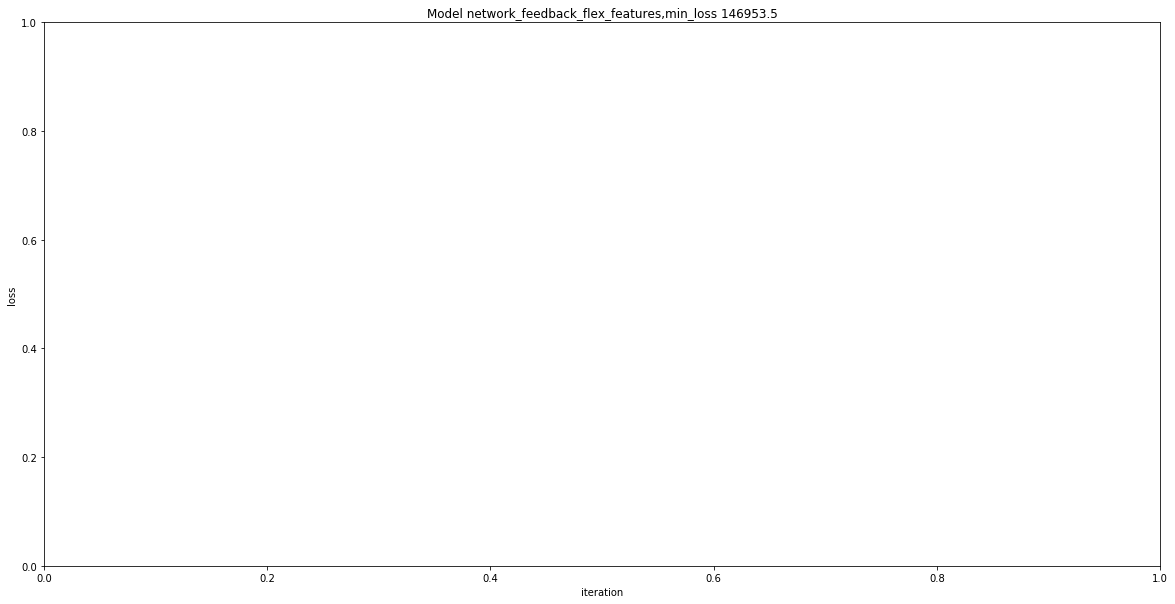

In [0]:
p = plotter("network_feedback_flex_features",learning_rate=learning_rate,iteration=iteration, seq_length=seq_length, stack_dim=stack_dim, hidden_dim=hidden_dim, rmse=rmse_val,prediction=np.asarray(prediction),label=testLabel, index=testIndex, flex_dim=flex_dim)

train_fig_name = now.strftime("%Y%m%d_%H%M_train")
train_fig_dir = fig_dir + '/' + train_fig_name    
p.plot_training_graph(loss,iteration,figloc=train_fig_dir)
print("Figure "+train_fig_name+" saved\n")

test_fig_name = now.strftime("%Y%m%d_%H%M_test")
test_fig_dir = fig_dir + '/' + test_fig_name
p.plot_comparison(subplot_row = 2, size = (20,10), figloc=test_fig_dir)
print("Figure "+test_fig_name+" saved\n")
test_data_name = now.strftime("%Y%m%d_%H%M_test.csv")

test_data_dir = fig_dir + '/' + test_data_name
test_data=np.concatenate((testIndex[:,0],testLabel,np.asarray(prediction)),axis=1)
np.savetxt(test_data_dir,test_data,delimiter=',')
print(f"Data {test_data_name} saved\n")